# Wie beschleunige ich meine Datenanalyse zuhause oder im Cluster

## Parallelisierung der Merkmalsberechnung mit python, joblib und dask

Zuerst initialisieren wir unsere Umgebung mit einigen Paketen. Falls es zu Fehlern kommt sollten die Pakete auf der Kommandozeile mit pip oder conda nachinstalliert werden.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import time
from tqdm import tqdm


import sys 
os.environ["PATH"] += os.pathsep + sys.prefix+'/bin'
    
%matplotlib inline
%config InteractiveShell.ast_node_interactivity="last_expr_or_assign"

Die folgenden Pfade müssen angepasst werden, sobald die Daten runtergeladen wurden (>800MB gepackt). Die Daten können unter https://bwsyncandshare.kit.edu/s/NzrXCAnTHDWJZRk heruntergeladen werden.

In [2]:
TRAIN_LABEL_PATH = "data/train_labels.csv"
TRAIN_PATH = "data/train/"

'data/train/'

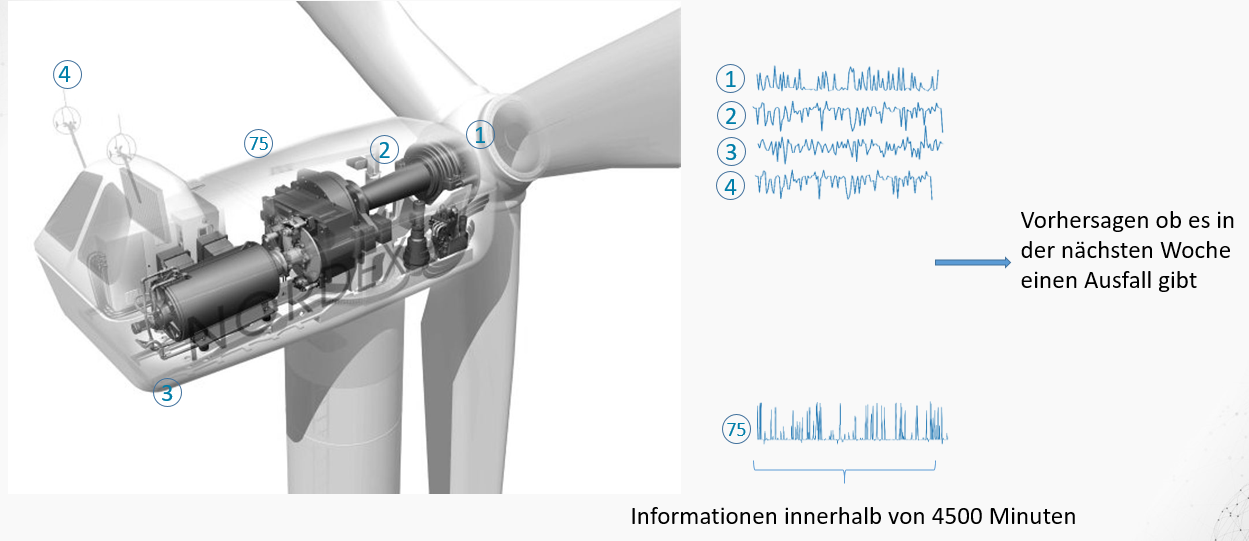

In [59]:
from IPython.display import Image
Image('images/data.PNG')

Die Daten sind von verschiedene Windrädern in China bei denen 75 Sensoren alle 10 Minuten aufgezeichnet wurden.

In [3]:
import pandas as pd
data= pd.read_csv("data/train/002/cbd192c9-5e59-3b3c-bae8-20f8ae9f2b36.csv")

,Wheel speed,hub angle,blade 1 angle,blade 2 angle,blade 3 angle,pitch motor 1 current,pitch motor 2 current,Pitch motor 3 current,overspeed sensor speed detection value,5 second yaw against wind average,...,blade 3 inverter box temperature,blade 1 super capacitor voltage,blade 2 super capacitor voltage,blade 3 super capacitor voltage,drive 1 thyristor temperature,Drive 2 thyristor temperature,Drive 3 thyristor temperature,Drive 1 output torque,Drive 2 output torque,Drive 3 output torque
0,14.63,154.01,0.24,0.31,0.22,12.48,13.58,14.00,14.91,2.6,...,300,0,0,0,0,0,0,0,0,0
1,13.74,312.77,0.24,0.31,0.22,11.36,11.14,13.06,13.95,8.7,...,300,0,0,0,0,0,0,0,0,0
2,13.55,73.76,0.24,0.31,0.22,11.74,11.90,14.64,13.81,5.4,...,300,0,0,0,0,0,0,0,0,0
3,12.21,132.26,0.24,0.31,0.22,10.08,10.30,12.20,12.47,-7.1,...,300,0,0,0,0,0,0,0,0,0
4,12.91,239.51,0.24,0.31,0.22,10.90,11.84,13.04,13.16,1.2,...,300,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,11.37,93.24,0.24,0.31,0.22,10.10,8.84,11.28,11.62,-27.1,...,300,0,0,0,0,0,0,0,0,0
446,14.37,194.51,0.24,0.31,0.22,12.20,13.46,14.64,14.65,1.6,...,300,0,0,0,0,0,0,0,0,0
447,12.31,82.76,0.24,0.31,0.22,10.00,10.10,12.02,12.60,-1.5,...,300,0,0,0,0,0,0,0,0,0
448,12.24,183.49,0.24,0.31,0.22,9.48,10.30,11.56,12.50,2.3,...,300,0,0,0,0,0,0,0,0,0


Soviele Minuten umfasst die Datei:

In [4]:
data.shape[0]*10

4500

Die Spalten sind Zeitreihen

<AxesSubplot:>

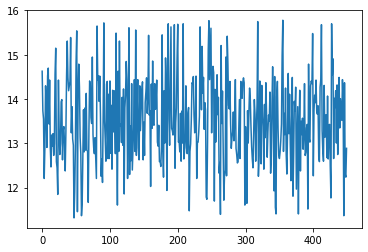

In [5]:
data["Wheel speed"].plot()

Zu jeder multidimensionalen Zeitreihe gehört ein Label: 1 wenn das Windrad danach einen Defekt hatte, ansonsten 0.  Die Herausforderung wird es sein den Defekt anhand der Zeitreihe vorherzusagen.

In [6]:
label=pd.read_csv(TRAIN_LABEL_PATH)

,f_id,file_name,ret
0,95,dba63ee5-6603-300e-8071-8536afcbc2de.csv,0
1,95,0b8bfa51-cf28-35d0-94d2-7922f45120b2.csv,0
2,95,d7a64eee-165e-3d39-be67-adc82050bde3.csv,0
3,95,4da3314d-c5b0-3782-bdd6-27fb9e251261.csv,0
4,95,7d58a65f-af5a-3433-bcbb-a342b9468b71.csv,0
...,...,...,...
48334,11,d6e19de9-22a8-39e6-98c1-cc599c819a56.csv,1
48335,11,83895667-dc4e-303a-90e7-7dfc0725f476.csv,1
48336,11,a6ab9f83-4bea-323f-b08e-4a9fb4eab8d6.csv,1
48337,11,a19af894-a9c8-3127-87e4-39567f0a9e0c.csv,1


Die Label sind bereits balanciert, was das Vorhersageproblem später einfacher macht. 

<AxesSubplot:>

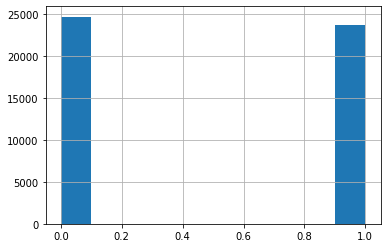

In [7]:
label["ret"].hist()

Um eine einfache Klassifikation auf das Label zu machen können Merkmale auf den Zeitreihen berechnet werden um kritische Ausprägungen mit einen Klassifikationsalgorithmus zu lernen. Das Schweizer Taschenmesser der Merkmalsextraktion ist https://github.com/blue-yonder/tsfresh der Karlsruher Firma BlueYonder

In [8]:
%%timeit -r1 -n1 -o
import tsfresh
data["id"]="a"
tsfresh.extract_features(data,n_jobs=1,column_id="id")

Feature Extraction: 100%|██████████| 5/5 [00:19<00:00,  4.00s/it]


29.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 29.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

Wenn man nun alle Dateien auf einer CPU Laden will so dauert das dann ca. so viele Stunden:

In [9]:
label.shape[0]*_.average/60/60

394.79091108894903

Zum Glück unterstützt tsfresh bereits Parallelisierung:Probieren Sie verschiedene Werte für n_jobs aus. Sie werden merken, dass die Parallelisierung nicht ganz linear skaliert

Um die Liste aller Dateien zu bekommen, müssen wir übrigens noch den Pfad dran hängen und den Ordner dreistellig kodieren. 

In [10]:
files=label.apply(lambda row: os.path.abspath(TRAIN_PATH+"{:03d}/{}".format(row["f_id"],row["file_name"])),axis=1)

0        /gpfs/smartdata/iu5681/src/Parallel_computing/...
1        /gpfs/smartdata/iu5681/src/Parallel_computing/...
2        /gpfs/smartdata/iu5681/src/Parallel_computing/...
3        /gpfs/smartdata/iu5681/src/Parallel_computing/...
4        /gpfs/smartdata/iu5681/src/Parallel_computing/...
                               ...                        
48334    /gpfs/smartdata/iu5681/src/Parallel_computing/...
48335    /gpfs/smartdata/iu5681/src/Parallel_computing/...
48336    /gpfs/smartdata/iu5681/src/Parallel_computing/...
48337    /gpfs/smartdata/iu5681/src/Parallel_computing/...
48338    /gpfs/smartdata/iu5681/src/Parallel_computing/...
Length: 48339, dtype: object

Die Daten einfach alle in den Speicher zu laden funktioniert übrigens auch nicht. Insgesamt sprechen wir über soviele Gigabyte:

In [11]:
from pathlib import Path
sum(Path(f).stat().st_size  for f in files) /(1024**3)

6.261525361798704

Nun kopieren wir die Teile von oben in eine Funktion um sie auf alle Dateien anzuwenden

In [12]:
def get_features(file):
    data= pd.read_csv(file)
    data["id"]=file
    return tsfresh.extract_features(data,disable_progressbar=True, n_jobs=1,column_id="id")

Damit es schneller geht können wir ein paar einfachere Features verwenden

In [13]:
def get_features(file):
    data= pd.read_csv(file)
    data["path"]=file
    return data.groupby("path").agg(["mean","var","min","max"])

Wir iterieren hierzu über alle Files und stecken Sie in einen Dataframe (zu Demozwecken nur die ersten 100). tqdm ist für die Statusanzeige zuständig

In [14]:
%%time
features=pd.concat(get_features(f) for f in tqdm(files[0:100]))

100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


CPU times: user 25.7 s, sys: 83.7 ms, total: 25.8 s
Wall time: 26.4 s


Python unterstützt von Haus aus nur einen Prozessor. Hier nutzen wir also nicht unseren Prozesser aus. Hierzu gibt es die joblib. Mit delayed werden die Berechnungen asyncron gestartet. Wenn man mehrere Prozessorkerne hat wird man durch die Erhöhung von n_jobs wie schon oben eine leichte Beschleunigung feststellen (Engpass ist meist die Festplatte).

In [15]:
%%time
from joblib import Parallel, delayed
features=pd.concat(Parallel(n_jobs=4)(delayed(get_features)(f) for f in tqdm(files[0:100])))

100%|██████████| 100/100 [00:07<00:00, 13.34it/s]


CPU times: user 7.12 s, sys: 264 ms, total: 7.39 s
Wall time: 9.18 s


Limitierend sind hier auch die CPUs und der RAM in einem Rechner. Sehr große Rechner sind meist extrem teuer. Billiger geht es im Cluster.  (HTCondor)[https://research.cs.wisc.edu/htcondor/] ist ein Clusterscheduler der von der Python Bibliothek (dask)[https://dask.org/] für verteiltes Rechnen unterstützt wird. Damit wird die Erstellung eines eigenen Clusters in einem Hochleistungs-Cluster einfach. Aber man kann hier auch viele Rechner im Firmennetzwerk zusammenschalten. (Geht auch über Kubernetes oder Yarn in der Cloud). Wir holen uns nun ein paar Rechner mit 8 Prozessorkernen und je 32GB RAM und ner kleinen Festplatte (wir wollen die Daten nur in den Speicher laden).

In [16]:
import dask.dataframe as dd
from dask_jobqueue import HTCondorCluster
from distributed import Client
from dask.distributed import progress


os.environ["_condor_SCHEDD_HOST"]="login-l.sdil.kit.edu"
cluster= HTCondorCluster(cores=8, memory= "32GB", disk="400MB")
client=Client(cluster)
cluster

Diese Konfiguration können wir nun in unserem Fall beliebig hochskalieren.

In [17]:
cluster.scale(160)

Unser Beispiel von oben lässt sich trivial beschleunigen. Wenn sie das Pythonpaket bokeh installiert haben können sie auf dem Dashboard (link oben) sehen wie die Funktion parallel auf dem Cluster ausgeführt wird. (Die Statusbar ist hier unsinnig, da alle jobs parallel in den Cluster geschickt werden)

In [18]:
%%time
from joblib import parallel_backend
with parallel_backend('dask'):
    features=pd.concat(Parallel()(delayed(get_features)(f) for f in tqdm(files[0:100])))

100%|██████████| 100/100 [00:08<00:00, 11.55it/s]


CPU times: user 6.8 s, sys: 306 ms, total: 7.1 s
Wall time: 11.6 s


Es geht aber noch einfacher. Die  Idee von Big Data ist es das Berechnungsgraphen auf großen verteilten Datenquellen ausgeführt werden.

In [19]:
ddf=dd.read_csv(TRAIN_PATH+"006/02*.csv",include_path_column=True)

,Wheel speed,hub angle,blade 1 angle,blade 2 angle,blade 3 angle,pitch motor 1 current,pitch motor 2 current,Pitch motor 3 current,overspeed sensor speed detection value,5 second yaw against wind average,x direction vibration value,y direction vibration value,hydraulic brake pressure,Aircraft weather station wind speed,wind direction absolute value,atmospheric pressure,reactive power control status,inverter grid side current,inverter grid side voltage,Inverter grid side active power,inverter grid side reactive power,inverter generator side power,generator operating frequency,generator current,generator torque,Inverter inlet temperature,inverter outlet temperature,inverter inlet pressure,inverter outlet pressure,generator power limit value,reactive power set value,Rated hub speed,wind tower ambient temperature,generator stator temperature 1,generator stator temperature 2,generator stator temperature 3,generator stator temperature 4,Generator stator temperature 5,generator stator temperature 6,generator air temperature 1,generator air temperature 2,main bearing temperature 1,main bearing temperature 2,Wheel temperature,Wheel control cabinet temperature,Cabin temperature,Cabin control cabinet temperature,Inverter INU temperature,Inverter ISU temperature,Inverter INU RMIO temperature,Pitch motor 1 power estimation,Pitch motor 2 power estimation,Pitch motor 3 power estimation,Fan current status value,hub current status value,yaw state value,yaw request value,blade 1 battery box temperature,blade 2 battery box temperature,blade 3 battery box temperature,vane 1 pitch motor temperature,blade 2 pitch motor temperature,blade 3 pitch motor temperature,blade 1 inverter box temperature,blade 2 inverter box temperature,blade 3 inverter box temperature,blade 1 super capacitor voltage,blade 2 super capacitor voltage,blade 3 super capacitor voltage,drive 1 thyristor temperature,Drive 2 thyristor temperature,Drive 3 thyristor temperature,Drive 1 output torque,Drive 2 output torque,Drive 3 output torque,path
npartitions=9,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,category[known]
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


Wir haben erstmal eine kleine Anzahl von Dateien geladen. Dask macht im Hintergrund allerdings nichts als automatisch eine Datenstruktur anzulegen. Wir können aber z.B. sehr schnell die ersten Daten anschauen (liest nur einen kleinen Auschnitt einer einzigen Datei).

In [20]:
ddf.head()

,Wheel speed,hub angle,blade 1 angle,blade 2 angle,blade 3 angle,pitch motor 1 current,pitch motor 2 current,Pitch motor 3 current,overspeed sensor speed detection value,5 second yaw against wind average,...,blade 1 super capacitor voltage,blade 2 super capacitor voltage,blade 3 super capacitor voltage,drive 1 thyristor temperature,Drive 2 thyristor temperature,Drive 3 thyristor temperature,Drive 1 output torque,Drive 2 output torque,Drive 3 output torque,path
0,1.77,339.01,21.0,21.01,21.0,1.88,2.64,1.76,1.78,-18.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/gpfs/smartdata/iu5681/src/Parallel_computing/...
1,1.82,123.01,21.0,21.01,21.0,1.10,2.54,1.58,1.82,-14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/gpfs/smartdata/iu5681/src/Parallel_computing/...
2,1.82,230.00,21.0,21.01,21.0,1.56,2.70,1.40,1.82,1.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/gpfs/smartdata/iu5681/src/Parallel_computing/...
3,1.73,33.98,21.0,21.01,21.0,0.80,2.70,0.86,1.74,-12.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/gpfs/smartdata/iu5681/src/Parallel_computing/...
4,1.75,82.01,21.0,21.01,21.0,1.64,2.70,1.82,1.78,-14.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/gpfs/smartdata/iu5681/src/Parallel_computing/...


Genauso können wir unsere Merkmalsextraktion wie oben spezifizieren. Hier brauchen wir jetzt nicht mehr die Daten in jeder Funktion einzulesen

In [21]:
dfeatures=ddf.groupby(['path']).agg(["mean","var","min","max"])

Dask DataFrame Structure:
              Wheel speed                            hub angle                            blade 1 angle                            blade 2 angle                            blade 3 angle                            pitch motor 1 current                            pitch motor 2 current                            Pitch motor 3 current                            overspeed sensor speed detection value                            5 second yaw against wind average                            x direction vibration value                            y direction vibration value                            hydraulic brake pressure                            Aircraft weather station wind speed                            wind direction absolute value                            atmospheric pressure                            reactive power control status                            inverter grid side current                            inverter grid side voltage                            Inverter grid side active power                            inverter grid side reactive power                            inverter generator side power                            generator operating frequency                            generator current                            generator torque                            Inverter inlet temperature                            inverter outlet temperature                            inverter inlet pressure                            inverter outlet pressure                            generator power limit value                            reactive power set value                            Rated hub speed                            wind tower ambient temperature                            generator stator temperature 1                            generator stator temperature 2                            generator stator temperature 3                            generator stator temperature 4                            Generator stator temperature 5                            generator stator temperature 6                            generator air temperature 1                            generator air temperature 2                            main bearing temperature 1                            main bearing temperature 2                            Wheel temperature                            Wheel control cabinet temperature                            Cabin temperature                            Cabin control cabinet temperature                            Inverter INU temperature                            Inverter ISU temperature                            Inverter INU RMIO temperature                            Pitch motor 1 power estimation                            Pitch motor 2 power estimation                            Pitch motor 3 power estimation                            Fan current status value                            hub current status value                            yaw state value                            yaw request value                            blade 1 battery box temperature                            blade 2 battery box temperature                            blade 3 battery box temperature                            vane 1 pitch motor temperature                            blade 2 pitch motor temperature                            blade 3 pitch motor temperature                            blade 1 inverter box temperature                            blade 2 inverter box temperature                            blade 3 inverter box temperature                            blade 1 super capacitor voltage                            blade 2 super capacitor voltage                            blade 3 super capacitor voltage                            drive 1 thyristor temperature                            Drive 2 thyristor temperature                            Drive 3 thyristor temperature                            Drive 1 output torque                            Drive 2 output

Wieder ist kaum was im Hintergrund passiert. Dask hat hier einen Berechnungsgraphen aufgebaut und die Datenstruktur für das Resultat angelegt.

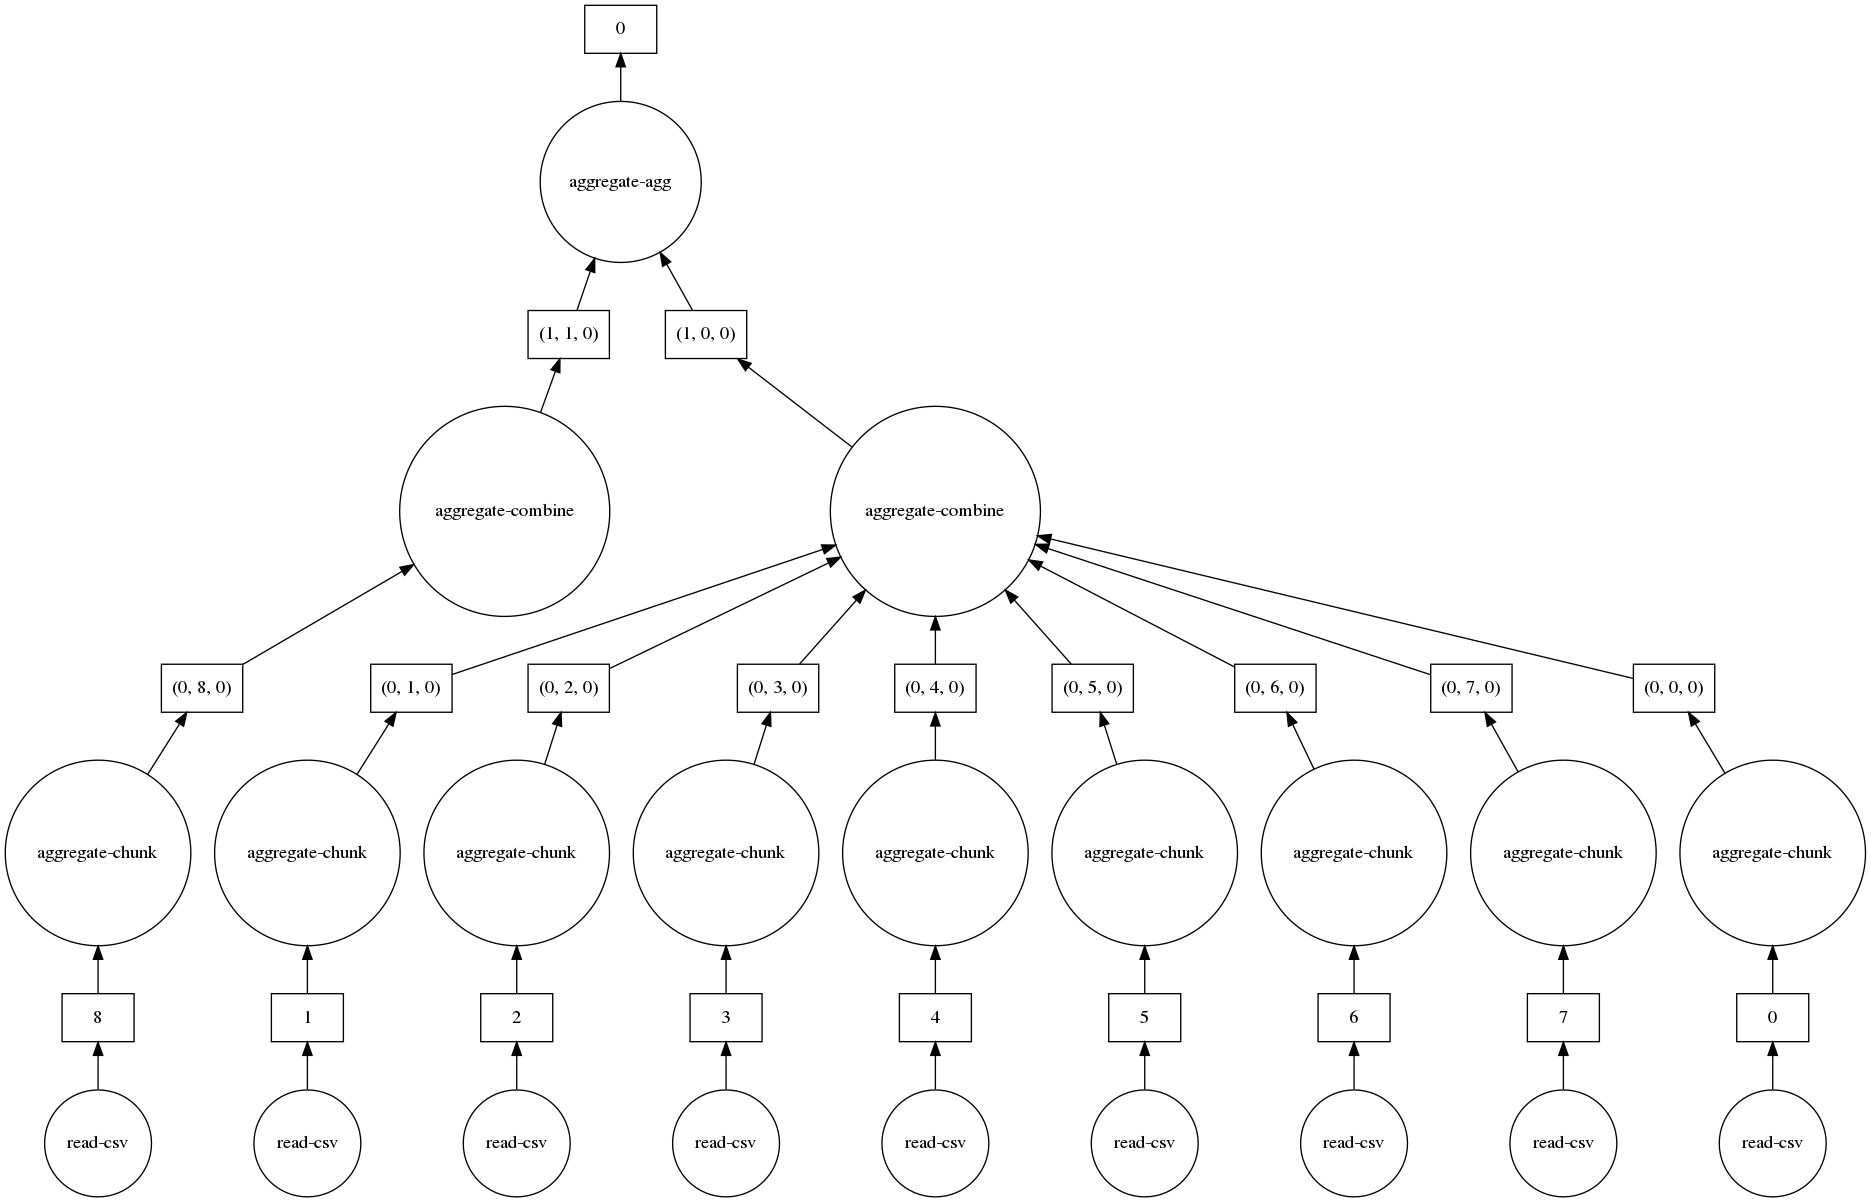

In [22]:
dfeatures.visualize()

Um die Berechnung zu demonstrieren wagen wir uns an etwas mehr Daten (Der Graph wird dann etwas zu groß um ihn noch im Notebook darzustellen, sonst ist alles gleich)

In [23]:
ddf=dd.read_csv(TRAIN_PATH+"006/*.csv",include_path_column=True)
dfeatures=ddf.groupby(['path']).agg(["mean","var","min","max"])

Dask DataFrame Structure:
              Wheel speed                            hub angle                            blade 1 angle                            blade 2 angle                            blade 3 angle                            pitch motor 1 current                            pitch motor 2 current                            Pitch motor 3 current                            overspeed sensor speed detection value                            5 second yaw against wind average                            x direction vibration value                            y direction vibration value                            hydraulic brake pressure                            Aircraft weather station wind speed                            wind direction absolute value                            atmospheric pressure                            reactive power control status                            inverter grid side current                            inverter grid side voltage                            Inverter grid side active power                            inverter grid side reactive power                            inverter generator side power                            generator operating frequency                            generator current                            generator torque                            Inverter inlet temperature                            inverter outlet temperature                            inverter inlet pressure                            inverter outlet pressure                            generator power limit value                            reactive power set value                            Rated hub speed                            wind tower ambient temperature                            generator stator temperature 1                            generator stator temperature 2                            generator stator temperature 3                            generator stator temperature 4                            Generator stator temperature 5                            generator stator temperature 6                            generator air temperature 1                            generator air temperature 2                            main bearing temperature 1                            main bearing temperature 2                            Wheel temperature                            Wheel control cabinet temperature                            Cabin temperature                            Cabin control cabinet temperature                            Inverter INU temperature                            Inverter ISU temperature                            Inverter INU RMIO temperature                            Pitch motor 1 power estimation                            Pitch motor 2 power estimation                            Pitch motor 3 power estimation                            Fan current status value                            hub current status value                            yaw state value                            yaw request value                            blade 1 battery box temperature                            blade 2 battery box temperature                            blade 3 battery box temperature                            vane 1 pitch motor temperature                            blade 2 pitch motor temperature                            blade 3 pitch motor temperature                            blade 1 inverter box temperature                            blade 2 inverter box temperature                            blade 3 inverter box temperature                            blade 1 super capacitor voltage                            blade 2 super capacitor voltage                            blade 3 super capacitor voltage                            drive 1 thyristor temperature                            Drive 2 thyristor temperature                            Drive 3 thyristor temperature                            Drive 1 output torque                            Drive 2 output

Die eigentliche Berechnung stoßen wir mit compute an. Jetzt sollte man wieder auf das Cluster dashboard wechseln. Am besten schaut man sich hier den Graph an. Hier kann man sehen wie nach und nach parallel die Daten eingelesen werden und das Ergebnis stückweise aggregiert wird. 

In [24]:
features=dfeatures.compute()

Wheel speed            \
                                                          mean       var   
path                                                                       
/gpfs/smartdata/iu5681/src/Parallel_computing/d...   11.652135  0.995131   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...    7.316793  0.121421   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...   14.688076  1.125021   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...   10.150067  1.033120   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...    7.151622  0.003039   
...                                                        ...       ...   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...    1.312825  6.887868   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...    7.355244  0.008396   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...    6.825356  0.590923   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...    8.051719  0.869359   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...    7.366778  0.002350   

                                                                  hub angle  \
                                                     min    max        mean   
path                                                                          
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  0.00  12.23  175.732668   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  0.00   7.47  179.592517   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  0.00  15.35  179.179799   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  7.99  12.18  184.451317   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  7.02   7.26  180.776289   
...                                                  ...    ...         ...   
/gpfs/smartdata/iu5681/src/Parallel_computing/d... -0.05   7.02   77.193371   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  7.13   7.64  179.541178   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  4.80   7.83  175.144556   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  0.00   9.93  176.688996   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  7.20   7.47  179.519911   

                                                                        \
                                                             var   min   
path                                                                     
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  11396.391191  0.00   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  10355.845285  0.00   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  10784.273071  0.00   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  10813.880820  0.00   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  10975.712335  1.01   
...                                                          ...   ...   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...   7435.980567  0.00   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  10948.732273  0.25   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  10654.435697  0.00   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  11072.518108  0.00   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  10488.953408  2.02   

                                                           blade 1 angle  \
                                                       max          mean   
path                                                                       
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  357.01      0.248260   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  360.00      0.267996   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  359.75      0.238926   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  357.98      4.434978   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  360.00      0.266978   
...                                                    ...           ...   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  357.98     70.065740   
/gpfs/smartdata/iu5681/src/Parallel_computing/d...  359.75      0.265311   
/gpfs/

Weil dask die Dateien nach und nach einliest, kann es auch zu Problemen bei der automatischen Erkennung der Spaltentypen kommen:

In [25]:
try: 
    features=dd.read_csv(TRAIN_PATH+"095/*.csv",include_path_column=True).\
            groupby(['path']).\
            agg(["mean","var","min","max"]).\
            compute()
except ValueError as e:
    print(e)

Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+-----------------------------------+---------+----------+
| Column                            | Found   | Expected |
+-----------------------------------+---------+----------+
| Drive 1 output torque             | float64 | int64    |
| Drive 2 output torque             | float64 | int64    |
| Drive 2 thyristor temperature     | float64 | int64    |
| Drive 3 output torque             | float64 | int64    |
| Fan current status value          | float64 | int64    |
| Inverter INU RMIO temperature     | float64 | int64    |
| Inverter INU temperature          | float64 | int64    |
| Inverter ISU temperature          | float64 | int64    |
| Inverter grid side active power   | float64 | int64    |
| Pitch motor 1 power estimation    | float64 | int64    |
| Pitch motor 2 power estimation    | float64 | int64    |
| Pitch motor 3 current             | float64 | int64    |
| Pitch motor 3 power estimation    | float64 | int64   

Hier hilft es die Typen manuell zu setzen (wir nutzen der Einfachheit halber einfach immer Fließkommazahlen). 

In [26]:
%time features=dd.read_csv(TRAIN_PATH+"095/*.csv",include_path_column=True, dtype='float64').\
            groupby(['path']).\
            agg(["mean","var","min","max"])
%time features=features.persist()

CPU times: user 2.56 s, sys: 568 ms, total: 3.12 s
Wall time: 2.98 s
CPU times: user 31 s, sys: 686 ms, total: 31.7 s
Wall time: 31.5 s


In [27]:
progress(features)

VBox()

`persist` belässt im Gegensatz zu `compute` das Berechnungsergebnis im Cluster und ist asyncron. Die erste Zeit ist die Zeit die es braucht den Graphen aufzubauen. Die zweite Zeit ist die Zeit, die es brauch den Task an den Cluster zu schicken.

In [33]:
from dask.distributed import wait
wait(features, timeout=30)
client.cancel(features)

Leider skaliert der Daskgraph hier mit der Anzahl der Dateien. Man beachte, dass hier gar nichts berechnet wird sondern nur der Graph lokal aufgebaut wird. Entsprechend lange dauert auch die Berechnung auf dem Cluster zu starten (währenddessen tut der Scheduler gar nichts). Am besten nicht auskommentieren: 16GB Speicher reichen nicht... 🙂

In [37]:
%time features=dd.read_csv(TRAIN_PATH+"*/*.csv",include_path_column=True, dtype='float64').\
            groupby(['path']).\
            agg(["mean","var","min","max"])
#%time features=features.persist()

CPU times: user 58.5 s, sys: 8.8 s, total: 1min 7s
Wall time: 1min 6s


In [38]:
#progress(features)

In [39]:
#from dask.distributed import wait
#wait(features, timeout=30)
#client.cancel(features)

Alternativ kann man in diesem Fall klassisches map-reduce mit unserer Funktion ```get_features``` von oben benutzen. Das hält den Graphen überschaubar klein.

In [44]:
import dask.bag as db

%time features=db.from_sequence(files).map(get_features).\
reduction(pd.concat,pd.concat)
%time features=features.persist()


CPU times: user 83.7 ms, sys: 6.03 ms, total: 89.8 ms
Wall time: 88.6 ms
CPU times: user 111 ms, sys: 2.99 ms, total: 114 ms
Wall time: 114 ms


In [45]:
progress(features)

VBox()

Um das Projekt abzuschließen können wir nun mit dem eigentlichen Maschinellen Lernen beginnen. Hierzu fügen wir die labels von oben an den Datensatz an und entfernen die Ids sowie evtl. Nulleinträge.

In [46]:
features=features.compute()
train=features.join(
    label.set_index(files)
).drop(['file_name','f_id'],axis=1).dropna()

,"(Wheel speed, mean)","(Wheel speed, var)","(Wheel speed, min)","(Wheel speed, max)","(hub angle, mean)","(hub angle, var)","(hub angle, min)","(hub angle, max)","(blade 1 angle, mean)","(blade 1 angle, var)",...,"(Drive 1 output torque, max)","(Drive 2 output torque, mean)","(Drive 2 output torque, var)","(Drive 2 output torque, min)","(Drive 2 output torque, max)","(Drive 3 output torque, mean)","(Drive 3 output torque, var)","(Drive 3 output torque, min)","(Drive 3 output torque, max)",ret
path,,,,,,,,,,,,,,,,,,,,,
/gpfs/smartdata/iu5681/src/Parallel_computing/data/train/095/dba63ee5-6603-300e-8071-8536afcbc2de.csv,13.394722,0.498932,0.00,14.14,172.347439,10709.343303,0.00,356.00,0.259421,0.000151,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
/gpfs/smartdata/iu5681/src/Parallel_computing/data/train/095/0b8bfa51-cf28-35d0-94d2-7922f45120b2.csv,14.962244,0.079155,14.32,15.51,174.595556,10632.927374,0.00,356.00,0.260000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
/gpfs/smartdata/iu5681/src/Parallel_computing/data/train/095/d7a64eee-165e-3d39-be67-adc82050bde3.csv,15.089200,0.287379,13.41,15.86,176.764444,10886.184925,0.00,356.00,0.260000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
/gpfs/smartdata/iu5681/src/Parallel_computing/data/train/095/4da3314d-c5b0-3782-bdd6-27fb9e251261.csv,13.077089,0.221067,11.87,14.15,170.177778,10579.442712,0.00,356.00,0.260000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
/gpfs/smartdata/iu5681/src/Parallel_computing/data/train/095/7d58a65f-af5a-3433-bcbb-a342b9468b71.csv,16.138867,0.037577,15.73,16.59,179.893333,10386.946281,0.00,356.00,0.261156,0.000574,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
/gpfs/smartdata/iu5681/src/Parallel_computing/data/train/011/d6e19de9-22a8-39e6-98c1-cc599c819a56.csv,0.066200,0.009512,-0.19,0.31,161.388044,11954.801024,0.50,359.64,92.240000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
/gpfs/smartdata/iu5681/src/Parallel_computing/data/train/011/83895667-dc4e-303a-90e7-7dfc0725f476.csv,0.055000,0.004598,-0.14,0.22,191.891689,3728.019529,109.87,304.74,92.240000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
/gpfs/smartdata/iu5681/src/Parallel_computing/data/train/011/a6ab9f83-4bea-323f-b08e-4a9fb4eab8d6.csv,0.008853,0.006387,-0.25,0.22,333.971078,430.780434,0.00,355.14,92.028440,19.514261,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


Um das Modell zu lernen und später zu überprüfen splitten wir die Daten und Trainings- und Testdaten. 

In [48]:
import sklearn as sk
import sklearn.model_selection 

X_train, X_test, y_train, y_test = sk.model_selection.train_test_split( 
    train.drop('ret', axis=1), train["ret"], test_size=0.33, random_state=42)

Nun können wir den Klassifikator lernen.

In [49]:
import sklearn.ensemble 

classifier = sk.ensemble.RandomForestClassifier()

RandomForestClassifier()

Auch wenn wir hier das Cluster zum Parallelisierung nutzen könnten, ist in dem Fall das Lernen so schnell dass es sich kaum lohnt. Hierzu müssten wir alle Daten und viel mehr Merkmale berechnen. Wer hier mehr wissen will sollte https://ml.dask.org/ lesen.

In [50]:
classifier.fit(X_train, y_train)

RandomForestClassifier()

Die Ergebnisse sind übrigens gar nicht mal so schlecht

In [51]:
print(sk.metrics.classification_report(y_test,classifier.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      8143
           1       0.97      0.98      0.97      7809

    accuracy                           0.97     15952
   macro avg       0.97      0.97      0.97     15952
weighted avg       0.97      0.97      0.97     15952



Wer sich Lust hat anzuschauen, was die verschiedenen Merkmale zur Klassifikation beitragen, kann sich auch noch mal einen Entscheidungbaum anschauen. 

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


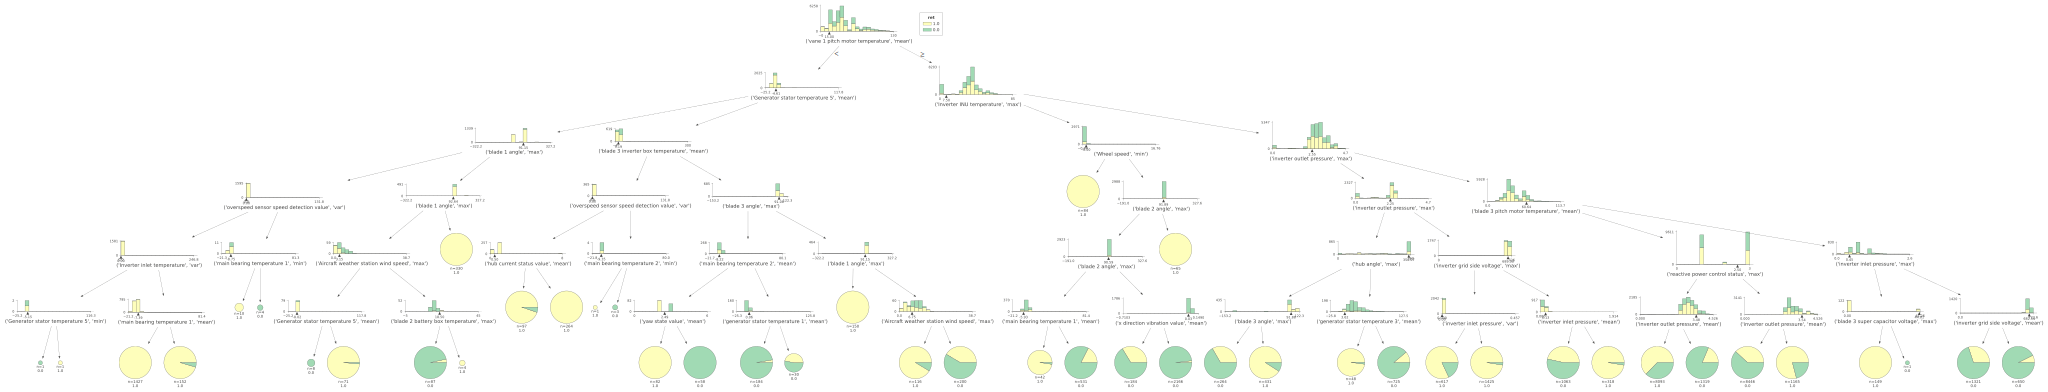

In [52]:
from dtreeviz.trees import *
classifier = sk.tree.DecisionTreeClassifier(max_depth=6)  # limit depth of tree

classifier.fit(X_train, y_train)

dtreeviz(classifier, 
               X_train, 
               y_train,
               target_name='ret',
               feature_names=X_train.columns, 
               class_names=["1.0", "0.0"]  # need class_names for classifier
              )  

Am Schluss fahren wir noch unsern Cluster runter, damit andere die CPUs wieder nutzen können :).  

In [53]:
cluster.scale(0)

In [54]:
client.restart()

Client Scheduler: tcp://141.52.224.192:36959 Dashboard: http://141.52.224.192:35111/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


Das Notebook wurde im Rahmen des [MWK-BW](https://mwk.baden-wuerttemberg.de/de/service/presse/pressemitteilung/pid/rechenpower-fuer-den-mittelstand-land-unterstuetzt-kleine-und-mittlere-unternehmen-bei-big-data/) geförderten [SDSC-BW Projektes](http://www.sdsc-bw.de) vom KIT TECO entwickelt und kann unter [CC-BY Lizenz](License.md) genutzt und weiterentwickelt werden.